In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch

In [2]:
data = pd.read_csv('data.csv')
target = np.array(data['y']==1)
data = data.drop(['Unnamed: 0','y'],axis=1)
X = np.array(data)
Y = target

In [3]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.7)
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

np.shape(X)

(11500, 178)

In [9]:
# Verifico las dimensiones de cada capa que planeo usar

X_new = np.expand_dims(X_train, 1) # necesario para que las dimensiones sean [batch, channel, width]
feature_maps = torch.autograd.Variable(torch.Tensor(X_new).float())
print(feature_maps.size())

n = torch.nn.Conv1d(1, 20, 8, stride=1) # in-channels = 1, out-channels = 10, kernel=8
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.MaxPool1d(kernel_size=3)
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.Conv1d(20, 1, 2, stride=1)
feature_maps = n(feature_maps)
print(feature_maps.size())

torch.Size([3450, 1, 178])
torch.Size([3450, 20, 171])
torch.Size([3450, 20, 57])
torch.Size([3450, 1, 56])


In [10]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 5, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=3),
    torch.nn.Conv1d(5, 1, kernel_size=2, stride=1),
    torch.nn.Linear(56, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

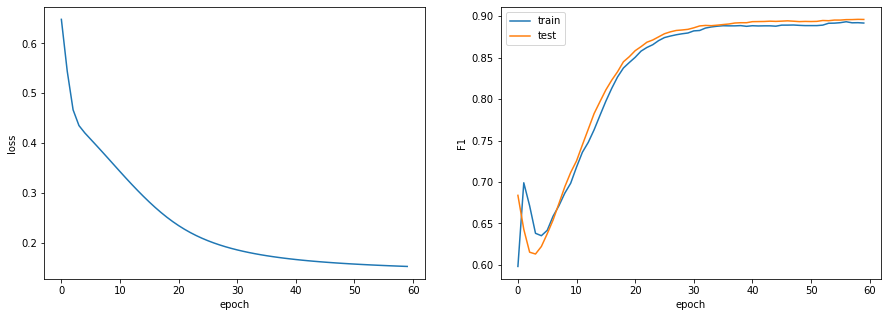

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()